In [2]:
import duckdb

conn = duckdb.connect("duckdb.db")

In [4]:
from jinja2 import Template

with open('performance_summary.sql') as f:
    template = Template(f.read())

In [33]:
conn.execute("select count(*) from 'data/acq.parquet';").fetchdf()

,count_star()
0,37015214


In [33]:
conn.execute("select count(*) from 'data/perf.parquet';").fetchdf()

,count_star()
0,1890353680


In [11]:
conn.execute("""PRAGMA enable_profiling='json';
PRAGMA profile_output='profile1.json';""")

In [12]:
%%time
summary = conn.execute(template.render(perf='data/perf.parquet', acq='data/acq.parquet')).fetchdf()

CPU times: user 35min 59s, sys: 43 s, total: 36min 42s
Wall time: 5min 20s


In [1]:
import json
import random

with open('profile.json') as f:
    s = json.loads(f.read())

In [2]:
from graphviz import Digraph

In [3]:
def plot_plan(nested_json):
    out = Digraph(node_attr={'shape': 'box'})
    def plot(x, pre=''):
        if type(x) is dict:
            r = random.random()
            label=f'''<<TABLE>
 <TR>
   <TD>{x['name']}</TD>
   <TD>{x['cardinality']}</TD>
 </TR>
</TABLE>>'''
            out.node(x['name']+ str(r),label)
            if pre != '':
                out.edge(pre, x['name']+str(r))
            plot(x['children'], x['name']+str(r))
        elif type(x) is list:
            for each in x:
                plot(each,pre)
                
    plot(nested_json)  
    return out
            

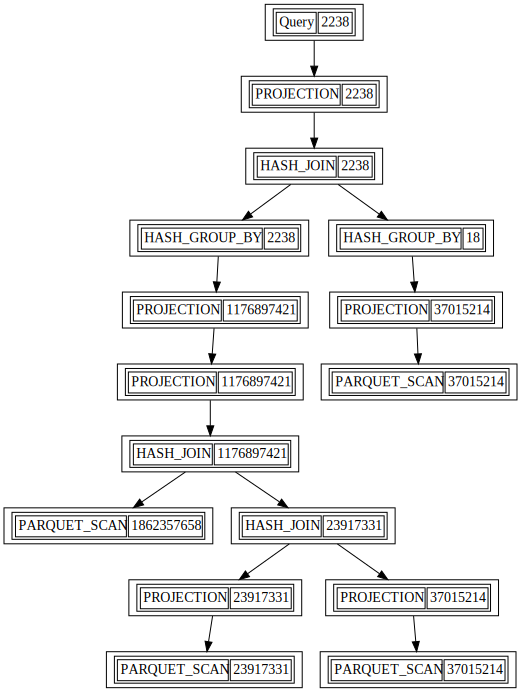

In [4]:
plot_plan(s)

In [ ]:
s['children']

[{'name': 'PROJECTION',
  'timing': 4e-06,
  'cardinality': 2238,
  'extra_info': 'orig_date\nstmt_number\nloan_count\navg_credit_score\ndq30_count\ndq90_count\ndq180_count\nupb_sum\nbad_cnt\ndollar_bad\n',
  'timings': [],
  'children': [{'name': 'HASH_JOIN',
    'timing': 0.000136,
    'cardinality': 2238,
    'extra_info': 'INNER\norig_date=orig_year\n',
    'timings': [],
    'children': [{'name': 'HASH_GROUP_BY',
      'timing': 1525.942075,
      'cardinality': 2238,
      'extra_info': '#0\n#1\navg(#2)\nsum(#3)\nsum(#4)\nsum(#5)\nsum(#6)\nsum(#7)\nsum(#8)',
      'timings': [],
      'children': [{'name': 'PROJECTION',
        'timing': 30.947027,
        'cardinality': 1176897421,
        'extra_info': 'orig_date\nstmt_number\nborrower_credit_score\ndq30\ndq90\ndq180\nCASE WHEN (IS_NOT_NULL(disposition_date)) THEN (#8) ELSE (0)\nCASE WHEN (IS_NOT_NULL(disposition_date)) THEN (#4) ELSE (0.000000)\ncurrent_actual_upb\n',
        'timings': [],
        'children': [{'name': 'PROJE

In [35]:
summary.head()

,orig_date,stmt_number,loan_count,avg_credit_score,dq30_count,dq90_count,dq180_count,upb_sum,bad_cnt,dollar_bad
0,2003,1.0,5107349,730.250014,3.0,0.0,0.0,1.539525e+09,0.0,0.00
1,2015,12.0,1859767,754.268143,1737.0,653.0,219.0,2.792753e+11,4.0,610859.83
2,2007,12.0,1252500,719.906212,10093.0,4207.0,1570.0,1.180344e+11,85.0,15810272.64
3,2003,2.0,5107349,730.238309,2193.0,0.0,0.0,3.354519e+09,0.0,0.00
4,2015,1.0,1859767,754.146714,0.0,0.0,0.0,3.798550e+08,0.0,0.00


In [36]:
len(summary)

2238

In [38]:
summary.groupby('orig_date').dollar_bad.sum()/summary.groupby('orig_date').upb_sum.max()

orig_date
1999    0.010162
2000    0.008756
2001    0.007439
2002    0.007903
2003    0.011534
2004    0.024403
2005    0.054939
2006    0.076471
2007    0.085242
2008    0.042009
2009    0.005343
2010    0.001708
2011    0.001052
2012    0.000468
2013    0.000466
2014    0.000451
2015    0.000124
2016    0.000011
dtype: float64

In [41]:
summary.groupby('orig_date').dollar_bad.sum()/1000000

orig_date
1999       70.077155
2000      777.610205
2001     1900.753022
2002     2387.863383
2003     4796.277209
2004     3892.794448
2005     7286.807932
2006     7534.837202
2007    10766.348260
2008     8334.439642
2009     1891.986702
2010      461.535448
2011      226.871168
2012      198.570496
2013      160.945776
2014       95.471593
2015       37.541039
2016        3.986943
Name: dollar_bad, dtype: float64

In [42]:
summary.groupby('orig_date').upb_sum.max()/1000000

orig_date
1999      6895.803828
2000     88811.632080
2001    255519.484153
2002    302131.499358
2003    415841.331122
2004    159519.343380
2005    132634.865129
2006     98532.018207
2007    126302.621067
2008    198396.018859
2009    354092.165484
2010    270236.918783
2011    215705.283798
2012    424393.687829
2013    345015.502776
2014    211697.728529
2015    302231.716916
2016    365848.360875
Name: upb_sum, dtype: float64

In [8]:
import duckdb_query_graph